# CNN Scratch

This notebook trains a Convolutional Neural Network (CNN) **from scratch** — meaning no pretrained weights or external model files are used. Every layer is initialized randomly and learned purely from our own handwritten digit dataset.

In [1]:
#%pip install torchvision torchsummary Pillow --quiet

In [2]:
# We import only what we need — no torchvision.models since we are not using any pretrained models
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset

from torchvision import transforms
from torchsummary import summary
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
# Detect the best available hardware (GPU, MPS, or CPU) so training runs as fast as possible
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Dataset

In [4]:
class HandwrittenDigitsDataset(Dataset):
    """
    Custom PyTorch Dataset that reads images from a folder structured as:
        root_dir/
            0/  <- images of digit 0
            1/  <- images of digit 1
            ...
            9/  <- images of digit 9

    Each image is opened as grayscale (single channel) because digit shapes
    carry all the information — colour is irrelevant and would only add noise.
    """

    def __init__(self, root_dir, transform=None):
        self.samples = []       # will hold (image_path, label) pairs
        self.transform = transform

        # Walk through each digit folder and collect all image paths with their label
        for label in range(10):
            folder = os.path.join(root_dir, str(label))
            if not os.path.isdir(folder):
                print(f"Warning: folder {folder} not found, skipping.")
                continue
            for fname in os.listdir(folder):
                if fname.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
                    self.samples.append((os.path.join(folder, fname), label))

        print(f"Loaded {len(self.samples)} images from {root_dir}")

    def __len__(self):
        # PyTorch needs to know how many samples are in the dataset
        return len(self.samples)

    def __getitem__(self, idx):
        # Called by the DataLoader for each batch — opens one image and returns it with its label
        path, label = self.samples[idx]
        img = Image.open(path).convert("L")   # "L" = grayscale, gives a single-channel image
        if self.transform:
            img = self.transform(img)
        return img, label

## Transforms & DataLoader

Before feeding images into the network we apply a short pipeline of transforms:
1. **Resize** — all images are standardised to 32×32 pixels
2. **ToTensor** — converts the PIL image to a float tensor in the range [0, 1]
3. **Normalize** — shifts pixel values so they are centred around 0 with a standard deviation of 1, which helps the network converge faster

In [5]:
# ── Paths ─────────────────────────────────────────────────────────────────────
OWN_DATA_DIR = "LT3_digits/LT3_digits"   # folder containing our handwritten digit images

IMAGE_SIZE = 32    # we resize every image to this square size
BATCH_SIZE = 16    # number of images processed together in one training step

# The scratch CNN takes 1-channel (grayscale) images.
# Normalise with mean=0.5 and std=0.5 so pixel values roughly span [-1, 1].
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load the full dataset using our custom class defined above
full_dataset = HandwrittenDigitsDataset(OWN_DATA_DIR, transform=transform)

# Split 80% for training, 20% for validation so we can monitor overfitting
val_size   = int(len(full_dataset) * 0.2)
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders wrap the datasets and handle batching and shuffling automatically.
# Training data is shuffled each epoch to prevent the model from memorising the order.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)

# Quick sanity check — should print [16, 1, 32, 32]: batch × channels × height × width
imgs, labels = next(iter(train_loader))
print(f"Batch shape: {imgs.shape}")
print(f"Train samples: {train_size}  |  Val samples: {val_size}")

Loaded 100 images from LT3_digits/LT3_digits
Batch shape: torch.Size([16, 1, 32, 32])
Train samples: 80  |  Val samples: 20


### Quick peek at the data

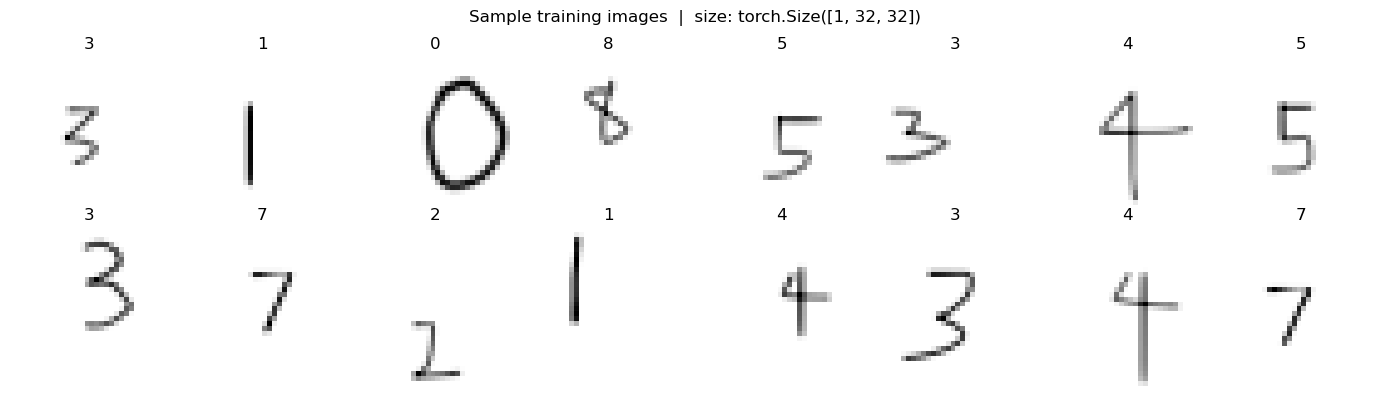

In [6]:
# Display the first 16 training images in a 2×8 grid with their digit labels
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 8, figsize=(14, 4))
for i in range(16):
    ax = axes[i // 8][i % 8]
    ax.imshow(images[i].squeeze(), cmap="gray")
    ax.set_title(labels[i].item())
    ax.axis("off")
plt.suptitle(f"Sample training images  |  size: {images[0].size()}")
plt.tight_layout()
plt.show()

## Scratch CNN Architecture

A CNN learns to recognise patterns by stacking three kinds of building blocks:

* **Convolutional layers** — slide small filters over the image to detect local patterns like edges and curves
* **Pooling layers** — shrink the spatial size to focus on *what* was detected rather than *exactly where*
* **Fully-connected (classifier) layers** — combine the detected patterns to make a final prediction

Because our dataset is very small (~100 images), we add regularisation at every block to prevent the model from simply memorising the training set:
* **BatchNorm** — normalises activations within each batch to stabilise training
* **LeakyReLU** — an activation function that keeps small negative signals alive instead of zeroing them out
* **Dropout2d** — randomly zeros out entire feature maps during training so the network cannot rely on any single feature

In [7]:
import torch
import torch.nn as nn


class DigitCNN(nn.Module):
    """
    A compact CNN trained entirely from scratch on our handwritten digit images.

    Architecture overview
    ─────────────────────
    Input  : 1 × 32 × 32  (grayscale image)
    Block 1: Conv(32) → Conv(32)  → Pool  →  16 × 16 feature maps
    Block 2: Conv(64) → Conv(64)  → Pool  →   8 ×  8 feature maps
    Block 3: Conv(128)→ Conv(128) → Pool  →   4 ×  4 feature maps
    GAP    : Global Average Pooling collapses spatial dims to 1 × 1
    Output : Linear(128 → 10)  — one score per digit class
    """

    def __init__(self, n_classes=10):
        super().__init__()

        self.features = nn.Sequential(

            # ── Block 1 ── learn simple features like edges and strokes ──────
            # First conv goes from 1 grayscale channel to 32 feature maps
            nn.Conv2d(1, 32, kernel_size=3, padding=1),   # keeps spatial size at 32×32
            nn.BatchNorm2d(32),                            # normalise activations per batch
            nn.LeakyReLU(0.1),                             # activation; 0.1 slope for negatives

            # Second conv refines the features within the same resolution
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),

            nn.Dropout2d(0.2),                             # drop 20% of feature maps randomly
            nn.MaxPool2d(2),                               # halve spatial size: 32×32 → 16×16

            # ── Block 2 ── combine simple features into curves and shapes ────
            # We double the channels so the network can represent more complex patterns
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),

            nn.Dropout2d(0.3),                             # slightly more aggressive dropout
            nn.MaxPool2d(2),                               # 16×16 → 8×8

            # ── Block 3 ── capture high-level digit structure ─────────────────
            # 128 channels let the network distinguish complex digit-level patterns
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),

            nn.Dropout2d(0.4),                             # strongest dropout at the deepest layer
            nn.MaxPool2d(2),                               # 8×8 → 4×4
        )

        # Global Average Pooling replaces a large fully-connected layer by averaging each
        # feature map down to a single number — fewer parameters means less overfitting
        self.gap = nn.AdaptiveAvgPool2d(1)                 # 128 × 4 × 4  →  128 × 1 × 1

        # Final linear layer maps the 128 feature scores to 10 digit classes
        self.classifier = nn.Linear(128, n_classes)

        # Initialise weights with methods suited to each layer type
        self._init_weights()

    def _init_weights(self):
        """Good weight initialisation prevents vanishing/exploding gradients at the start."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Kaiming init is designed for ReLU-family activations
                nn.init.kaiming_normal_(m.weight, nonlinearity="leaky_relu")
            elif isinstance(m, nn.Linear):
                # Xavier init keeps variance balanced through linear layers
                nn.init.xavier_normal_(m.weight)

    def forward(self, x):
        """Defines how data flows through the network — called automatically by PyTorch."""
        x = self.features(x)      # pass through all three convolutional blocks
        x = self.gap(x)           # global average pool: [B, 128, 4, 4] → [B, 128, 1, 1]
        x = x.view(x.size(0), -1) # flatten to [B, 128] so we can feed it into Linear
        x = self.classifier(x)    # produce raw scores (logits) for each of the 10 classes
        return x

In [8]:
# Instantiate the model and move it to the selected device (CPU or GPU)
model = DigitCNN().to(device)

# Print a layer-by-layer breakdown of parameters and output shapes
print("=== DigitCNN — Built from Scratch ===")
summary(model, (1, 32, 32))

=== DigitCNN — Built from Scratch ===
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             320
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         LeakyReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         LeakyReLU-6           [-1, 32, 32, 32]               0
         Dropout2d-7           [-1, 32, 32, 32]               0
         MaxPool2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
      BatchNorm2d-10           [-1, 64, 16, 16]             128
        LeakyReLU-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,928
      BatchNorm2d-13           [-1, 64, 16, 16]             128
 

## Training

Training adjusts the model weights using **gradient descent** — we measure how wrong the predictions are with a loss function, then propagate that error backwards through the network to update every weight in the direction that reduces the loss.

Key choices:
* **CrossEntropyLoss with label smoothing** — smoothing slightly softens the target labels so the model does not become overconfident on a tiny training set
* **Adam optimiser** — an adaptive learning-rate method that usually converges faster than plain SGD
* **50 epochs** — one epoch means the model has seen every training image once

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=50):
    """Train the model and track loss and accuracy for both training and validation sets."""

    train_losses, val_losses = [], []
    train_accs,   val_accs   = [], []

    for epoch in range(epochs):

        # ── Training phase ────────────────────────────────────────────────────
        # model.train() enables dropout and batchnorm in training mode
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()          # clear gradients from the previous step
            preds = model(X_batch)         # forward pass: compute predictions
            loss  = criterion(preds, y_batch)  # compare predictions to true labels
            loss.backward()                # backward pass: compute gradients
            optimizer.step()              # update weights using the computed gradients

            running_loss += loss.item()
            correct      += (preds.argmax(1) == y_batch).sum().item()
            total        += y_batch.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accs.append(correct / total)

        # ── Validation phase ─────────────────────────────────────────────────
        # model.eval() disables dropout and fixes batchnorm statistics
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():             # no gradients needed — saves memory and time
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                preds      = model(X_val)
                val_loss  += criterion(preds, y_val).item()
                val_correct += (preds.argmax(1) == y_val).sum().item()
                val_total   += y_val.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_correct / val_total)

        # Print a progress update every 5 epochs so we can monitor training
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1:3d}/{epochs}]  "
                  f"Train loss: {train_losses[-1]:.4f}  acc: {train_accs[-1]:.4f}  |  "
                  f"Val loss: {val_losses[-1]:.4f}  acc: {val_accs[-1]:.4f}")

    return train_losses, val_losses, train_accs, val_accs

In [10]:
EPOCHS = 50
LR     = 0.001

# Re-create the model so we start from random weights every time this cell is run
model     = DigitCNN().to(device)

# CrossEntropyLoss combines a softmax with negative log-likelihood in one numerically stable step.
# label_smoothing=0.1 stops the model from becoming overly confident — useful for small datasets.
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Adam adapts the learning rate for each parameter individually, which often gives faster convergence
optimizer = optim.Adam(model.parameters(), lr=LR)

print("Training Scratch CNN...")
train_loss, val_loss, train_acc, val_acc = train_model(
    model, train_loader, val_loader,
    criterion, optimizer, device, epochs=EPOCHS
)

Training Scratch CNN...
Epoch [  5/50]  Train loss: 2.7830  acc: 0.1000  |  Val loss: 2.4298  acc: 0.1000
Epoch [ 10/50]  Train loss: 2.4525  acc: 0.1750  |  Val loss: 2.2646  acc: 0.2000
Epoch [ 15/50]  Train loss: 2.3031  acc: 0.1625  |  Val loss: 2.4229  acc: 0.1000
Epoch [ 20/50]  Train loss: 2.1011  acc: 0.2750  |  Val loss: 2.1377  acc: 0.2000
Epoch [ 25/50]  Train loss: 1.9292  acc: 0.3250  |  Val loss: 2.0694  acc: 0.1500
Epoch [ 30/50]  Train loss: 1.8579  acc: 0.3750  |  Val loss: 1.8898  acc: 0.3000
Epoch [ 35/50]  Train loss: 1.7098  acc: 0.4500  |  Val loss: 1.8363  acc: 0.3000
Epoch [ 40/50]  Train loss: 1.5125  acc: 0.5125  |  Val loss: 1.6078  acc: 0.3500
Epoch [ 45/50]  Train loss: 1.4510  acc: 0.5375  |  Val loss: 1.3172  acc: 0.6000
Epoch [ 50/50]  Train loss: 1.2410  acc: 0.6875  |  Val loss: 1.2911  acc: 0.7000


## Training Curves

Plotting loss and accuracy over epochs tells us whether the model is learning properly:
* If training accuracy keeps rising but validation accuracy stalls or drops, the model is **overfitting** (memorising rather than learning)
* Ideally both curves should trend downward/upward together

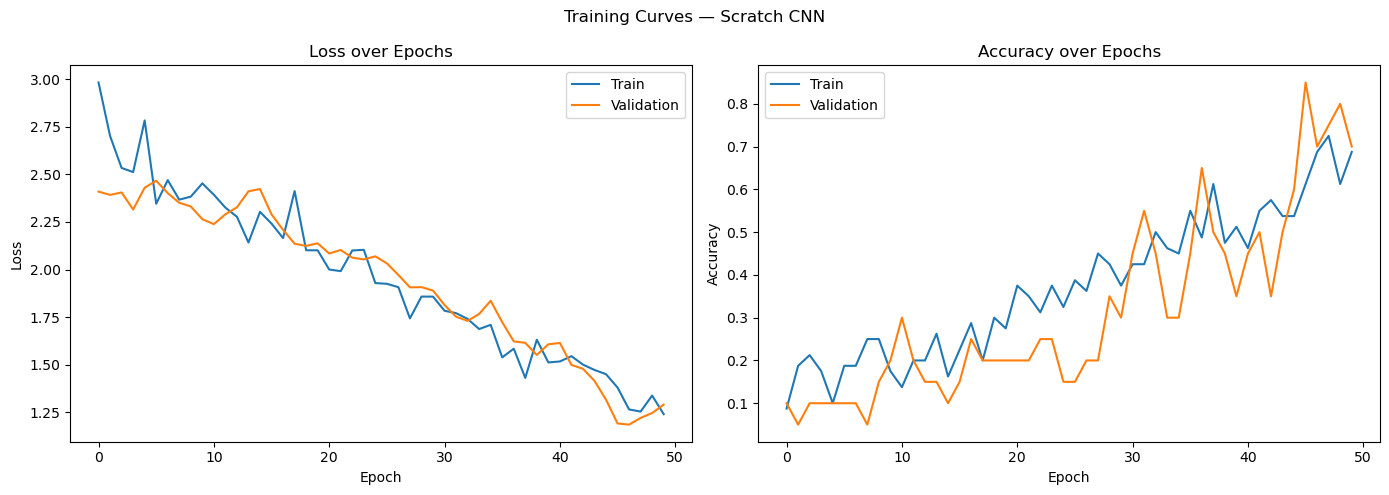

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves — lower is better
axes[0].plot(train_loss, label="Train")
axes[0].plot(val_loss,   label="Validation")
axes[0].set_title("Loss over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Accuracy curves — higher is better
axes[1].plot(train_acc, label="Train")
axes[1].plot(val_acc,   label="Validation")
axes[1].set_title("Accuracy over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.suptitle("Training Curves — Scratch CNN")
plt.tight_layout()
plt.show()

## Evaluation

After training we evaluate on the held-out validation set to get an unbiased measure of performance. We look at:
* **Classification report** — per-class precision, recall and F1-score
* **Confusion matrix** — shows exactly which digits get confused with each other
* **Prediction grid** — a visual sample of what the model predicted vs the true label

In [13]:
def show_batch(images, labels, preds, n=16, title=""):
    """Display a grid of images annotated with true label (top) and predicted label (bottom)."""
    plt.figure(figsize=(14, 8))
    for i in range(min(n, len(images))):
        plt.subplot(4, 4, i + 1)
        img = images[i].squeeze()

        # Undo the normalisation (mean=0.5, std=0.5) to bring pixel values back to [0, 1]
        img = img * 0.5 + 0.5
        img = img.clamp(0, 1)

        plt.imshow(img.numpy(), cmap="gray")
        color = "green" if preds[i] == labels[i] else "red"
        plt.title(f"T:{labels[i]} P:{preds[i]}", color=color, fontsize=8)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


def evaluate_model(model, loader, dataset_name, device):
    """Run the trained model on a dataset and print a full performance report."""

    model.eval()
    all_preds, all_labels, all_images = [], [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            preds  = model(images).argmax(dim=1)   # pick the class with the highest score
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_images.append(images.cpu())

    all_images = torch.cat(all_images)

    print(f"{'='*60}")
    print(f"  Scratch CNN  |  Dataset: {dataset_name}")
    print(f"{'='*60}")

    # Classification report shows per-digit precision, recall and F1
    print(classification_report(all_labels, all_preds,
                                target_names=[str(i) for i in range(10)],
                                labels=list(range(10)),
                                zero_division=0))

    # Confusion matrix — rows are true labels, columns are predicted labels
    # High values on the diagonal mean the model predicts that digit correctly
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=range(10), yticklabels=range(10))
    plt.title(f"Confusion Matrix — Scratch CNN on {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # Visual grid of predictions so we can spot which images fool the model
    show_batch(all_images, all_labels, all_preds, n=16,
               title=f"Scratch CNN on {dataset_name}")

    acc = sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
    return acc

  Scratch CNN  |  Dataset: LT3 (ours)
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       1.00      1.00      1.00         3
           5       1.00      0.33      0.50         3
           6       0.50      1.00      0.67         2
           7       1.00      1.00      1.00         1
           8       1.00      0.25      0.40         4
           9       0.50      1.00      0.67         1

    accuracy                           0.70        20
   macro avg       0.75      0.71      0.67        20
weighted avg       0.88      0.70      0.70        20



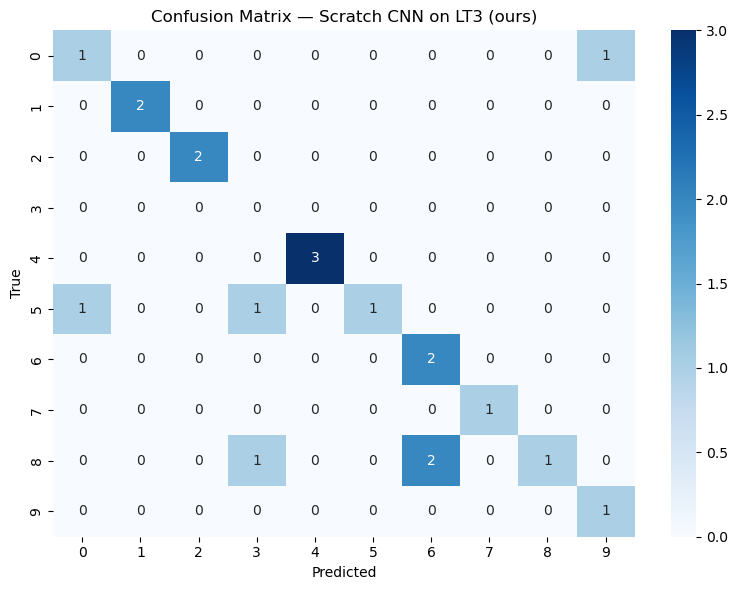

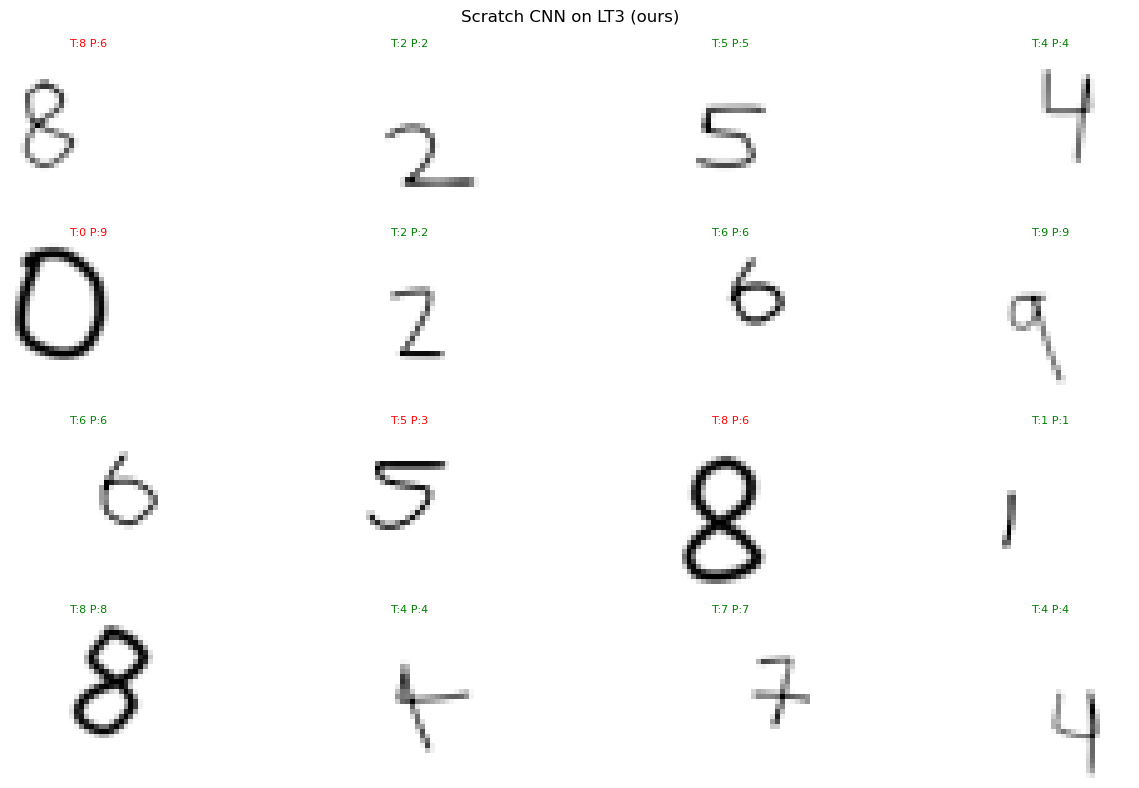

In [14]:
# Evaluate on our own validation split
acc_own = evaluate_model(model, val_loader, dataset_name="LT3 (ours)", device=device)

## Other LT Dataset Test

Run this block after receiving another team's dataset. Update  to the correct path, then uncomment and run.

Loaded 100 images from LT02_digits/LT02_digits
  Scratch CNN  |  Dataset: Other Team
              precision    recall  f1-score   support

           0       0.12      0.80      0.21        10
           1       0.43      0.30      0.35        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.50      0.10      0.17        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.25      0.10      0.14        10
           9       0.50      0.30      0.38        10

    accuracy                           0.16       100
   macro avg       0.18      0.16      0.12       100
weighted avg       0.18      0.16      0.12       100



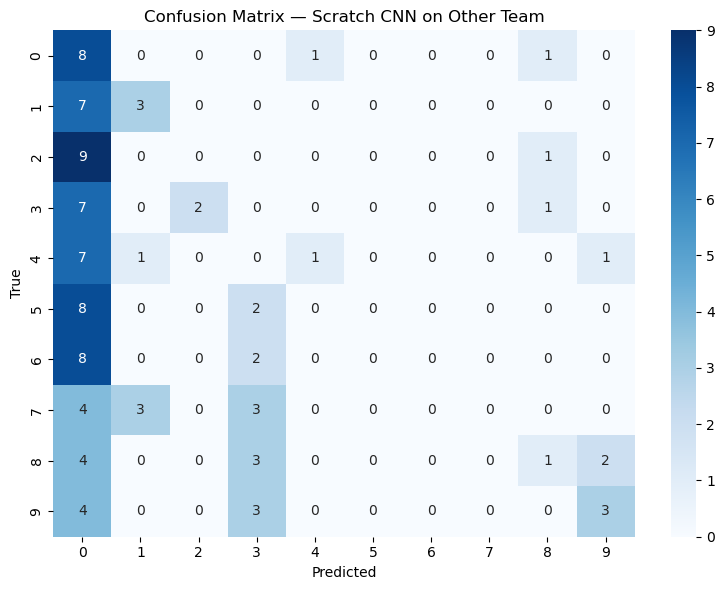

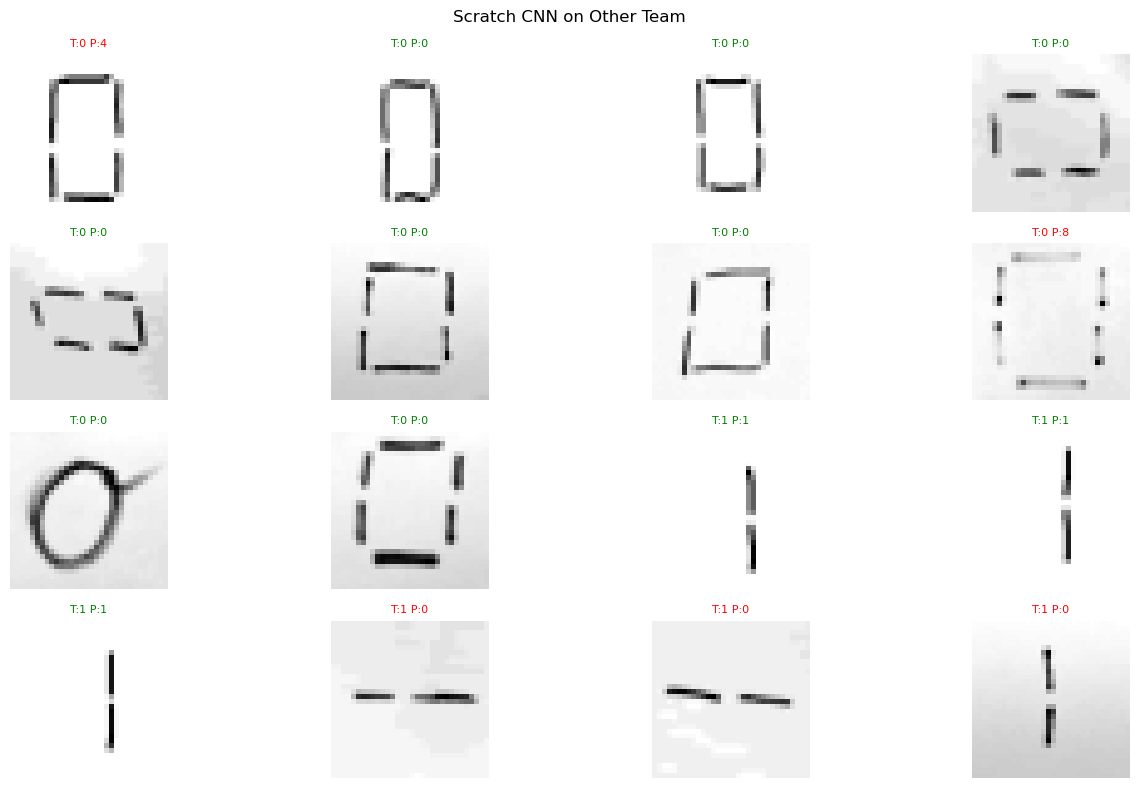

In [15]:
# ── Uncomment and update the path when you have the other team's data ──────────
OTHER_DATA_DIR = "LT02_digits/LT02_digits"

other_dataset = HandwrittenDigitsDataset(OTHER_DATA_DIR, transform=transform)
other_loader  = DataLoader(other_dataset, batch_size=BATCH_SIZE, shuffle=False)

acc_other = evaluate_model(model, other_loader, dataset_name="Other Team", device=device)

## Summary

In [19]:
print("" + "="*55)
print(f"{'Model':<25} {'Dataset':<20} {'Val Acc':>8}")
print("-"*55)
print(f"{'Scratch CNN':<25} {'LT3 (ours)':<20} {acc_own*100:>7.1f}%")
print(f"{'Scratch CNN':<25} {'Other Team':<20} {acc_other*100:>7.1f}%")
print("="*55)

Model                     Dataset               Val Acc
-------------------------------------------------------
Scratch CNN               LT3 (ours)              70.0%
Scratch CNN               Other Team              16.0%
